In [68]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import io
import sys
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import random
from sketchrnn_ouatai import models, dataset, utils
from PIL import Image

In [69]:
best_images = {
    'bulldozer': np.load('/home/romain/code/Tchook115/raw_data/best_bulldozer_100_epochs.npy', allow_pickle=True),
    'rabbit' : np.load('/home/romain/code/Tchook115/raw_data/best_rabbit.npy', allow_pickle=True), 
    'cat' : np.load('/home/romain/code/Tchook115/raw_data/best_cat.npy', allow_pickle=True),
    'ant' : np.load('/home/romain/code/Tchook115/raw_data/best_ant.npy', allow_pickle=True),
    'basket' : np.load('/home/romain/code/Tchook115/raw_data/best_basket.npy', allow_pickle=True)
}
fichiers = {
        'bulldozer': 'models_sketch_rnn_bulldozer_weights.100.hdf5', 
        'cat' : 'sketch_rnn_cat_weights.78_0.01.hdf5',
        'rabbit' : 'sketch_rnn_rabbit_weights.100_0.06.hdf5',
        'ant' : ' models_sketch_rnn_ant_weights.100.hdf5',
        'basket' : 'models_sketch_rnn_basket_weights.200.hdf5'
               }
words = ['bulldozer', 'cat', 'rabbit', 'ant', 'basket']

In [70]:
def df_to_calque(df,*args):
    pass

In [74]:
df_to_calque(2,2,'ro','rtr')

In [75]:
def dessine_moi_un(word, temperature = 0.3, color = 'black', zoom = 1):
    
    if word not in words:
        return 'essaie un autre mot stp'
    
    #test de variables random
    max_seq_len = best_images[word][0].shape[0]-1
    data_train = [1 for k in range(10000)]
    
    hps = {
        "max_seq_len": max_seq_len,
        'batch_size': 100,
        "num_batches": math.ceil(len(data_train) / 100),
        "epochs": 1,
        "recurrent_dropout_prob": 0.1,
        "enc_rnn_size": 256,
        "dec_rnn_size": 512,
        "z_size": 128,
        "num_mixture": 20,
        "learning_rate": 0.001,
        "min_learning_rate": 0.00001,
        "decay_rate": 0.9999,
        "grad_clip": 1.0,
        'kl_tolerance': 0.2,
        'kl_decay_rate': 0.99995,
        "kl_weight": 0.5,
        'kl_weight_start': 0.01,
    }
    
    # load model
    encoderrnn = None
    decoderrnn = None
    sketchrnn = models.SketchRNN(hps)
    initial_epoch, initial_loss = 100, 0.06
    
    checkpoint = os.path.join('../../raw_data/models/', fichiers[word])
    sketchrnn.load_weights(checkpoint)
    
    # building image 
    best_pic = random.choice(best_images[word])
    d = np.expand_dims(best_pic,0)
    z = sketchrnn.models['encoder'].predict(d[:,1:])[0]
    strokes = sketchrnn.sample(z=z, temperature=temperature)
    
    final_object = utils.to_normal_strokes(strokes)
    figheight = 3*zoom
    figwidth = 3*zoom
    figsize = (figheight,figwidth)
    fig, ax = plt.subplots(figsize=figsize,)
    utils.plot_strokes(ax, final_object, ec = color, linewidth=4)
    
    # figure to PIL image
    buf = io.BytesIO()
    fig.savefig(buf, format='png',pad_inches=0,transparent=True)
    buf.seek(0)
    image = Image.open(buf)
    image = image.copy()
    buf.close()
    return image

In [76]:
scene_size=(2560,1600)

In [77]:
def construis_la_scene(list_objects, scene_size = scene_size):
    '''
    list_objects = [[img_obj1, position_obj1], ...]
    '''
    scene = Image.new('RGBA', scene_size)
    for obj in list_objects:
        scene.paste(obj[0], obj[1])
        #scene = Image.alpha_composite(scene, obj[0])
    return scene

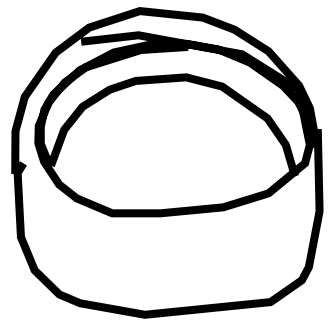

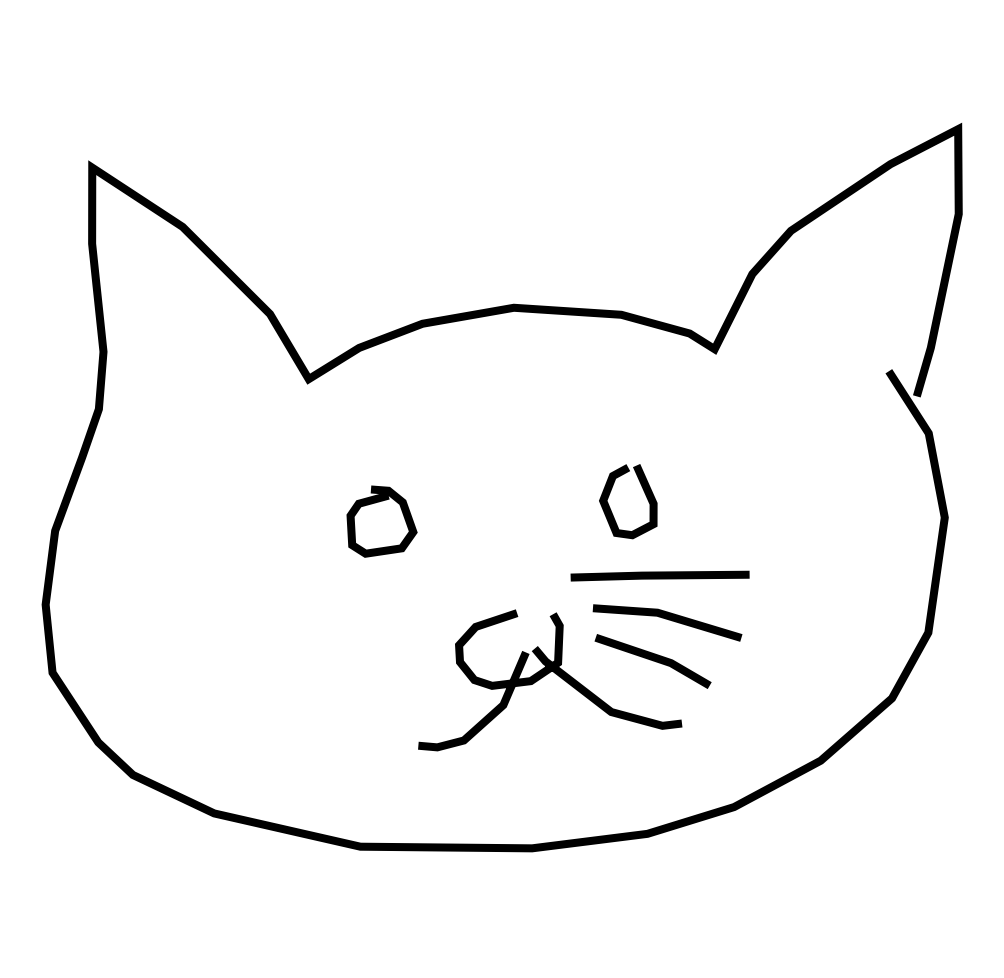

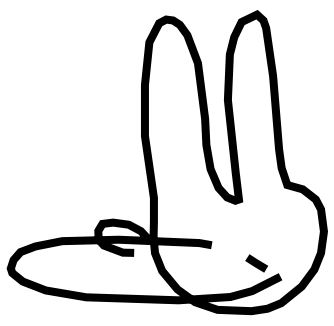

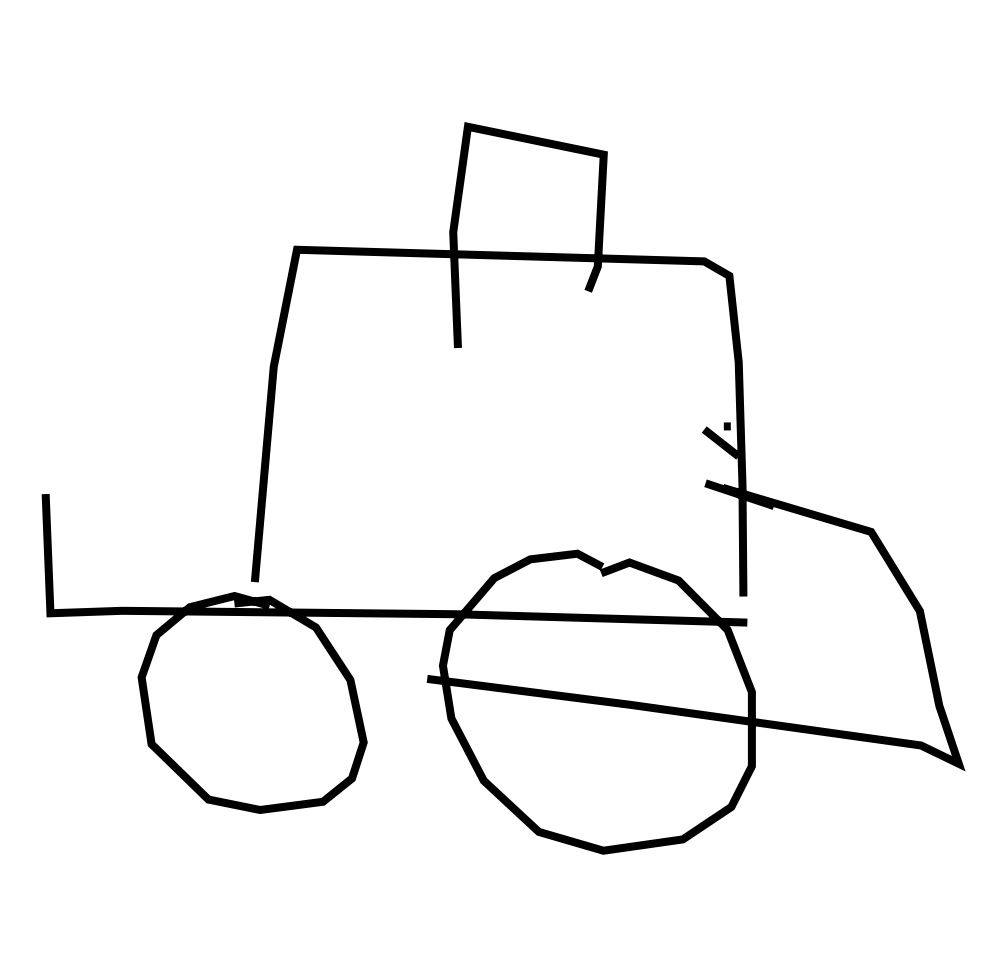

In [78]:
basket1 = dessine_moi_un('basket')
cat1 = dessine_moi_un('cat',zoom = 3)
rabbit2 = dessine_moi_un('rabbit')
bulldozer2 = dessine_moi_un('bulldozer',zoom = 3)

In [79]:
liste1=[[basket1,(0,0)],[cat1,(int(2000/3),0)]]
liste2=[[rabbit2,(0,int(2000/3))],[bulldozer2,(int(1000/3),int(2000/3))]]

In [80]:
bg = Image.open('praire.png').convert("RGBA")

In [81]:
scene1=construis_la_scene(liste1, scene_size = scene_size)
scene2=construis_la_scene(liste2, scene_size = scene_size)

In [82]:
def calque_merger(current_scene, new_scene):
    final1 = Image.new("RGBA", current_scene.size)
    final1.paste(current_scene, (0,0), current_scene)
    final1.paste(new_scene, (0,0), new_scene)
    return final1

In [83]:
calqueinter = calque_merger(bg,scene1)
calquefinal = calque_merger(calqueinter,scene2)

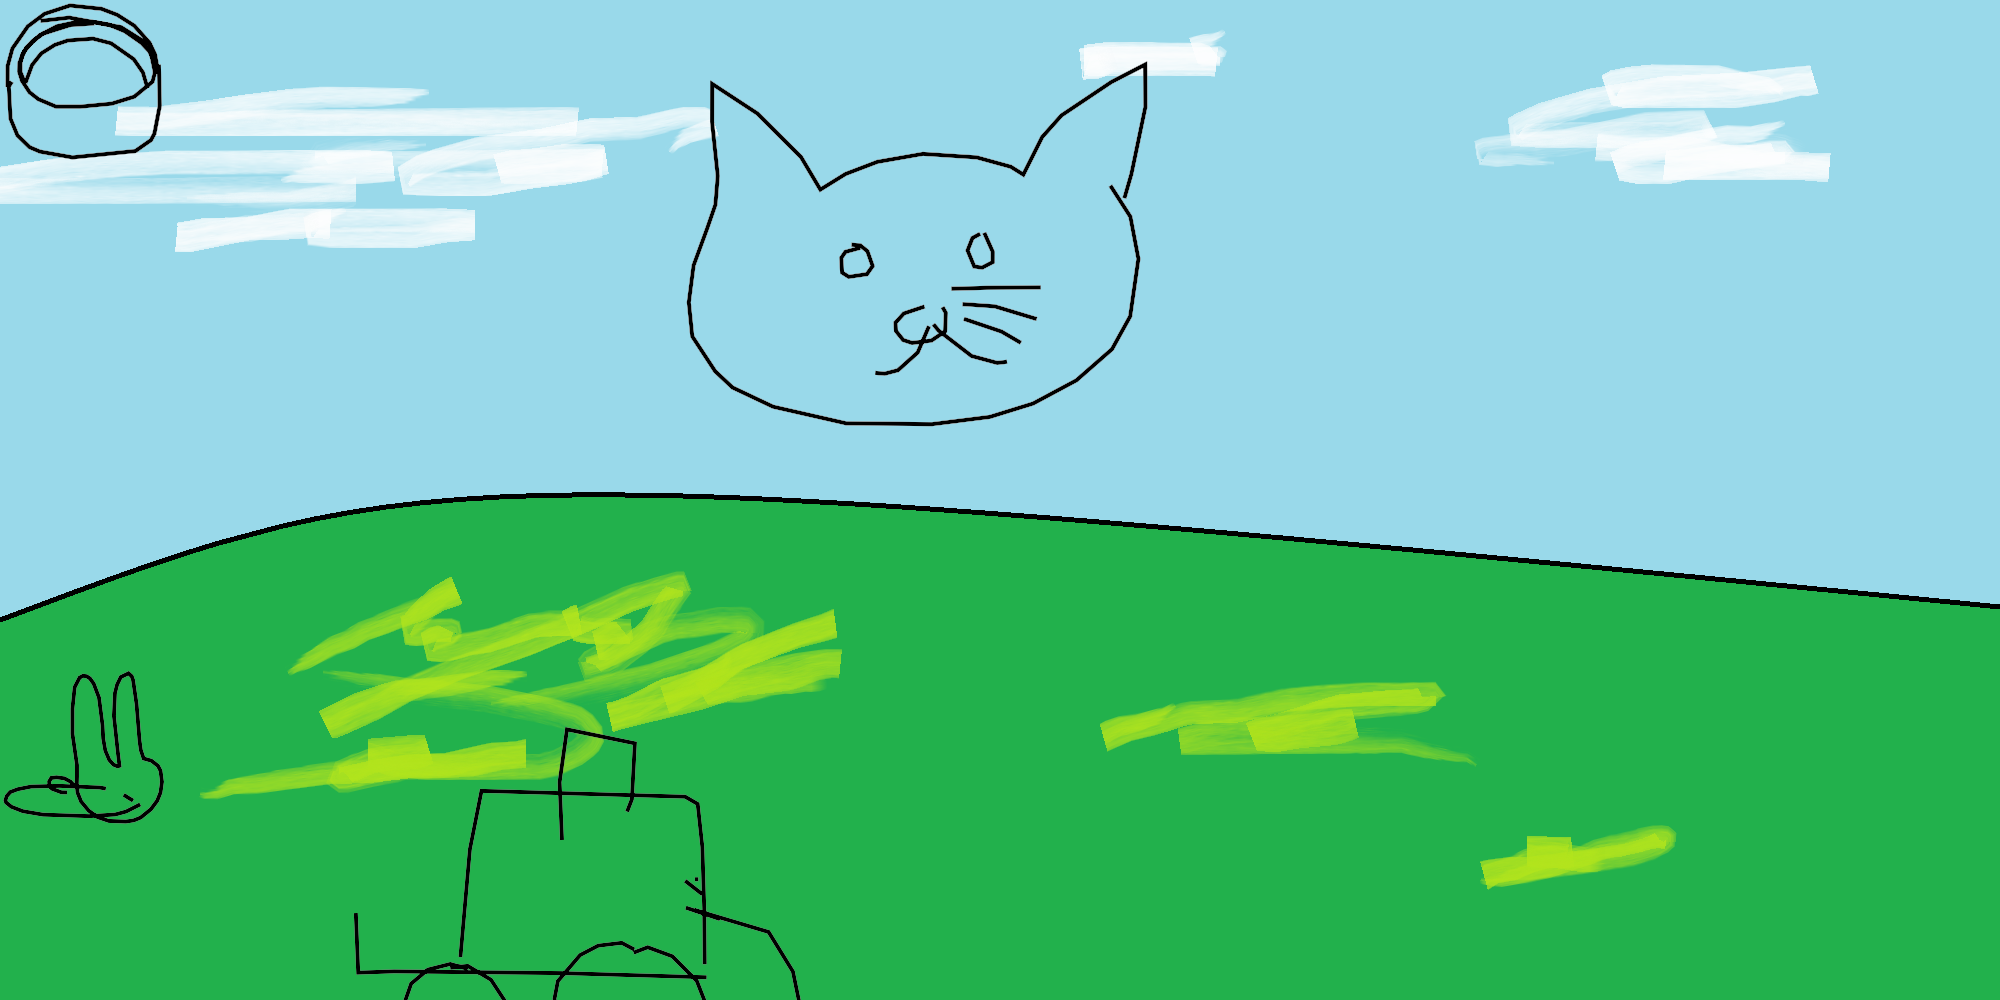

In [84]:
calquefinal